In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from rouge_score import rouge_scorer

In [11]:
retrieval_strategy = "colbert"
model = "llama-2-13b-chat.Q4_K_M"

persist_directory = "./../embeddings"
index_root = "../../colbert_index/"
colbert_path = "../../colbertv2.0/"
index_path = "../../colbert_index/colbert/indexes/documents/"

## Evaluation with ROUGE

In [12]:
with open(f"./cache/{retrieval_strategy}_{model}_responses.pickle", "rb") as handle:
    rag_responses = pickle.load(handle)

In [13]:
for i in range(len(rag_responses["question"])):
    print(rag_responses["question"][i])
    print(">>>", rag_responses["ground_truth"][i])
    print("-" * 100)
    print(rag_responses["answer"][i])
    print("")
    print("=" * 100)
    print("=" * 100)
    print("")

Which class involves time series analysis?
>>> Data Mining II, SIADS 632 includes a particular focus on time series analysis.
----------------------------------------------------------------------------------------------------
  Sure! Based on the information provided, the answer to the question "Which class involves time series analysis?" is:

Data Mining II (SIADS 632).


Who teaches the SQL and Databases class?
>>> The primary instructor for SQL and Databases is Graham Hukill. Additional course assistants include, Derek Bruckner, Emily Schemanske, Jungseo Lee, and Toby Kemp.
----------------------------------------------------------------------------------------------------
  Based on the information provided, the instructor of the SQL and Databases class is Graham Hukill (gshukill@umich.edu).


What are the prerequisites for Data Science for Social Good?
>>> SIADS 630, 631, and 694
----------------------------------------------------------------------------------------------------


In [14]:
responses_df = pd.DataFrame(rag_responses)

responses_df["eye_check"] = [
    1, # 'Which class involves time series analysis?',
    1, # 'Who teaches the SQL and Databases class?',
    0, # 'What are the prerequisites for Data Science for Social Good?',
    0, # 'When are the office hours for the Math Methods course?',
    1, # 'Are there any weekly readings for Milestone II?',
    1, # 'What are the outcomes of Qualitative Inquiry?',
    1, # 'What textbook is required for SIADS 505?',
    1, # 'What textbook is required for Data Manipulation?',
    1, # 'Which week of unsupervised learning covers DBSCAN?',
    1, # 'How many credits are required to complete the MADS program?',
    1, # 'How long do students have to complete the MADS program start to finish?',
    1, # 'How many points is the comprehensive oral exam worth in SIADS 593?',
    1, # 'What is the penalty for late submission in SIADS 630?',
    1, # 'How do I get accommodations for a class?',
    1, # 'What is a backpack?',
    1, # 'When is the latest I can drop a course?',
    1, # 'How do I get an override to take a class?',
    1, # 'How do I take a leave of absence from the MADS program?',
    1, # 'What are the prerequisites for Search and Recommender Systems?'
]

In [16]:
scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)


def calculate_rouge(row):
    scores = scorer.score(row["ground_truth"], row["answer"])
    return {
        "rouge1_f1": scores["rouge1"].fmeasure,
        "rouge2_f1": scores["rouge2"].fmeasure,
        "rougeL_f1": scores["rougeL"].fmeasure,
    }


scored_responses = responses_df.copy()
scored_responses[["rouge1_f1", "rouge2_f1", "rougeL_f1"]] = scored_responses.apply(
    calculate_rouge, axis=1, result_type="expand"
)

In [17]:
scored_responses.head()

,question,contexts,answer,ground_truth,eye_check,rouge1_f1,rouge2_f1,rougeL_f1
0,Which class involves time series analysis?,"[Data Mining II (SIADS 632), Syllabus SIADS 63...","Sure! Based on the information provided, the...","Data Mining II, SIADS 632 includes a particula...",1,0.500000,0.352941,0.277778
1,Who teaches the SQL and Databases class?,"[SQL and Databases (SIADS 511), Instructor And...","Based on the information provided, the instr...",The primary instructor for SQL and Databases i...,1,0.380952,0.200000,0.380952
2,What are the prerequisites for Data Science fo...,"[Data Science for Social Good (SIADS 688), Cou...","Based on the provided course syllabi, the pr...","SIADS 630, 631, and 694",0,0.222222,0.186047,0.222222
3,When are the office hours for the Math Methods...,"[Math Methods II (SIADS 602), Course Schedule:...","Based on the information provided, the offic...",Office hours for Math Methods are held at the ...,0,0.526316,0.351351,0.500000
4,Are there any weekly readings for Milestone II?,"[Milestone II (SIADS 696), Weekly Readings: Th...","Based on the information provided, there are...",There is introductory material during the firs...,1,0.303030,0.129032,0.242424


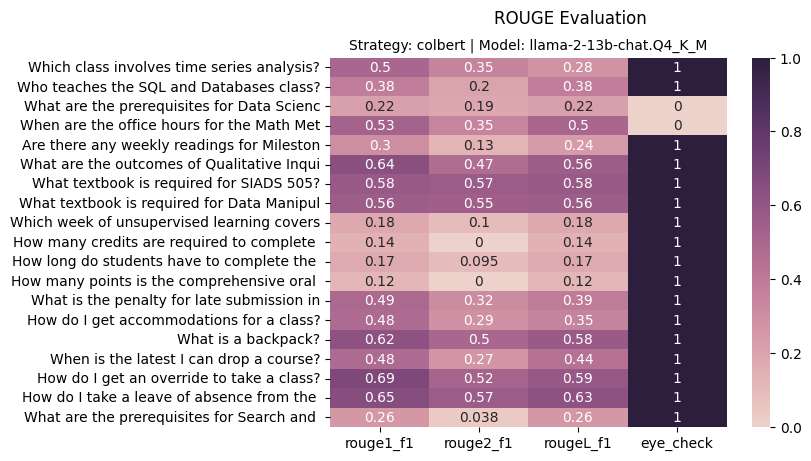

In [18]:
sns.heatmap(
    scored_responses[["rouge1_f1", "rouge2_f1", "rougeL_f1", "eye_check"]],
    yticklabels=scored_responses["question"].str[:42],
    annot=True,
    cmap=sns.cubehelix_palette(as_cmap=True),
)

plt.suptitle("ROUGE Evaluation")
plt.title(f"Strategy: {retrieval_strategy} | Model: {model}", fontsize=10)

plt.show()